# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

models        = []
strategyArray = []
gainArray     = []
lossArray     = []
ampNumber     = 3

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
originalDataSet = originalDataSet.sample(frac = 1, random_state = 5)

binaryDataSet   = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []

for i in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + i])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + i + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    
    return features, result

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScaler.inverse_transform(auxArray)[0][0]

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScaler.inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2):
    return abs(invertGainNorm(value1) - invertGainNorm(value2))

def getLossError(value1, value2):
    return abs(invertLossNorm(value1) - invertLossNorm(value2))

Using TensorFlow backend.


# Model setup

In [2]:
def initModels():
    models = []
    
    for i in range(ampNumber):
        models.append(MultiOutputRegressor(KNeighborsRegressor()))
    
    return models
        

# Cross validation function

In [3]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            gainError += getGainError(predicted[0], expected[0]) 
            lossError += getLossError(predicted[1], expected[1])
                 
        gainErrors.append((gainError / ampNumber) / foldSize)
        lossErrors.append((lossError / ampNumber) / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [4]:
def trainModel(models):   
    features, result       = loadDataset()
    gainErrors, lossErrors = crossValidate(models[0], features, result[:, 0: 2])
    
    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)\n" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    strategyArray.append("KNN - Amp 1")
    
    prediction = models[0].predict(features)
    for i in range(1, ampNumber):
        gainErrors, lossErrors = crossValidate(models[i], np.hstack((features, prediction)), result[:, i * 2: i * 2 + 2])

        print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
        print(lossErrors, "=> %0.2f (+/- %0.2f)\n" % (np.mean(lossErrors), lossErrors.std() * 2))

        gainArray.append(gainErrors)
        lossArray.append(lossErrors)
        strategyArray.append("KNN - Amp {}".format(i + 1))
        
        prediction = models[i].predict(np.hstack((features, prediction)))
    
    return gainErrors, lossErrors

# Plotting functions

In [5]:
def plotDistribution(models):
    train_results = []
    test_results  = []
    features, result                 = loadDataset()
    X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.3, random_state = 5)
    
    models[0].fit(X_train, y_train[:, 0: 2])
    train_results.append(models[0].predict(X_train))
    test_results.append(models[0].predict(X_test))
    
    for i in range(1, ampNumber):
        models[i].fit(np.hstack((X_train, train_results[i - 1])), y_train[:, i * 2: i * 2 + 2])
        train_results.append(models[i].predict(np.hstack((X_train, train_results[i - 1]))))
        test_results.append(models[i].predict(np.hstack((X_test, test_results[i - 1]))))
    
    fig   = plt.figure(figsize = (15, 5))
    vGain = np.vectorize(invertGainNorm)
    vLoss = np.vectorize(invertLossNorm)
    
    for i in range(ampNumber):
        ax = fig.add_subplot(1, 3, i + 1)
        
        ax.scatter(vGain(y_test[:, ampNumber * 2 - 2]), vLoss(y_test[:, ampNumber * 2 - 1]))
        ax.scatter(vGain(test_results[i][:, 0]), vLoss(test_results[i][:, 1]), c = "m")
        ax.set_title("Amplifier {}".format(i + 1))
    
    fig.suptitle("Test Error", fontsize = 16)
    fig.text(0.5, 0.04, 'Gain', ha='center', va='center', fontsize = 14)
    fig.text(0.06, 0.5, 'Loss', ha='center', va='center', rotation='vertical', fontsize = 14)
    fig.legend(["expected", "predicted"])

    plt.show()
    return y_test, test_results

In [6]:
def plotGainError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = gainArray

    axis.boxplot(data)
    axis.set_title("Train Gain Error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [7]:
def plotLossError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = lossArray

    axis.boxplot(data)
    axis.set_title("Train Loss Error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [8]:
def plotLinkTestError(yTest, predicted):
    fig, axis = plt.subplots(figsize = (10, 5))
    lossData  = [] 
    gainData  = [] 
    
    yTestGain     = yTest[:, 0]
    yTestLoss     = yTest[:, 1]
    predictedGain = np.array(predicted[0][:, 0]).flatten()
    predictedLoss = np.array(predicted[0][:, 1]).flatten()
    
    for i in range(1, ampNumber):
        yTestGain     = np.hstack((yTestGain, yTest[:, i * 2]))
        yTestLoss     = np.hstack((yTestLoss, yTest[:, i * 2 + 1]))
        predictedGain = np.hstack((predictedGain, np.array(predicted[i][:, 0]).flatten()))
        predictedLoss = np.hstack((predictedLoss, np.array(predicted[i][:, 1]).flatten()))
    
    for i in range(len(yTestGain)):
        lossData.append(getLossError(predictedLoss[i], yTestLoss[i]))
        gainData.append(getGainError(predictedGain[i], yTestGain[i]))
            
    print("Loss error mean: {}. Loss error median: {}".format(np.mean(lossData), np.median(lossData)))
    print("Gain error mean: {}. Gain error median: {}".format(np.mean(gainData), np.median(gainData)))
    
    axis.boxplot([lossData, gainData])
    axis.set_title("Link Test Error", fontsize = 16)
    axis.set_xticklabels(["Gain", "Loss"])
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [9]:
def plotLearningCurves(ampNumber, model, X, y, cv):
    fig, axis                              = plt.subplots(figsize = (10, 5))
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, 
                                                            train_sizes = np.linspace(0.1, 1.0, 6),
                                                            scoring = "neg_mean_squared_error")
       
    train_scores = -train_scores
    test_scores  = -test_scores

    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std  = np.std(train_scores, axis = 1)
    test_scores_mean  = np.mean(test_scores, axis = 1)
    test_scores_std   = np.std(test_scores, axis = 1)
    
    print("Size splits: {}".format(train_sizes))
    print("Train scores: {} ".format(train_scores_mean))
    print("Test scores: {} ".format(test_scores_mean))

    # Plot learning curve
    axis.plot(train_sizes, train_scores_mean, 'o-', color = "r", label = "Training score")
    axis.plot(train_sizes, test_scores_mean, 'o-', color = "g", label = "Test score")
    axis.set_title("Learning Error - Amplifier {}".format(ampNumber + 1), fontsize = 16)
    axis.set_xlabel("Train size", fontsize = 14)
    axis.set_ylabel("MSE", fontsize = 14)
    axis.legend(loc = "best")
    
    plt.show()

# Putting all together

In [10]:
gainArray = []
lossArray = []

In [11]:
models = initModels()
trainModel(models)

[0.64168147 0.56044997 0.64333925 0.60817052 0.63244523] => 0.62 (+/- 0.06)
[0.71024275 0.68502072 0.70301954 0.77134399 0.73818828] => 0.72 (+/- 0.06)

[0.28525755 0.31734754 0.32693902 0.29319124 0.31805802] => 0.31 (+/- 0.03)
[1.01184133 0.97986975 0.99798697 0.92575488 1.04120782] => 0.99 (+/- 0.08)

[0.29082297 0.29330965 0.25352279 0.2875074  0.26110124] => 0.28 (+/- 0.03)
[0.07815275 0.04831261 0.06394316 0.05719361 0.07211368] => 0.06 (+/- 0.02)



(array([0.29082297, 0.29330965, 0.25352279, 0.2875074 , 0.26110124]),
 array([0.07815275, 0.04831261, 0.06394316, 0.05719361, 0.07211368]))

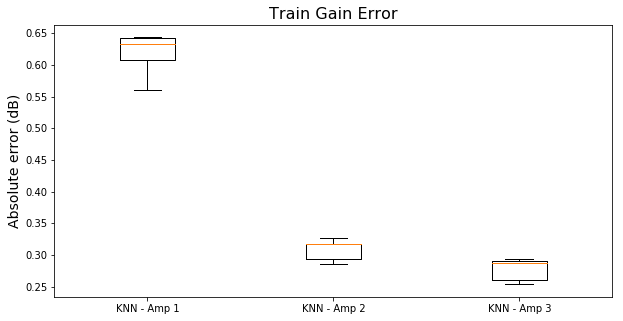

In [12]:
plotGainError()

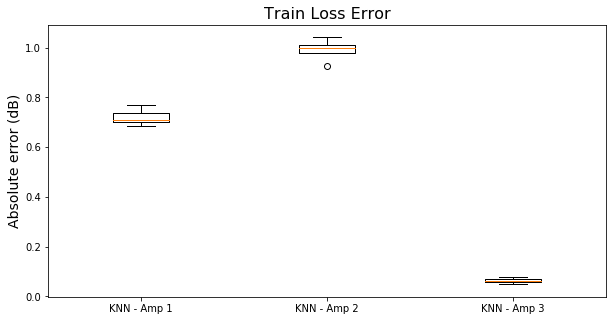

In [13]:
plotLossError()

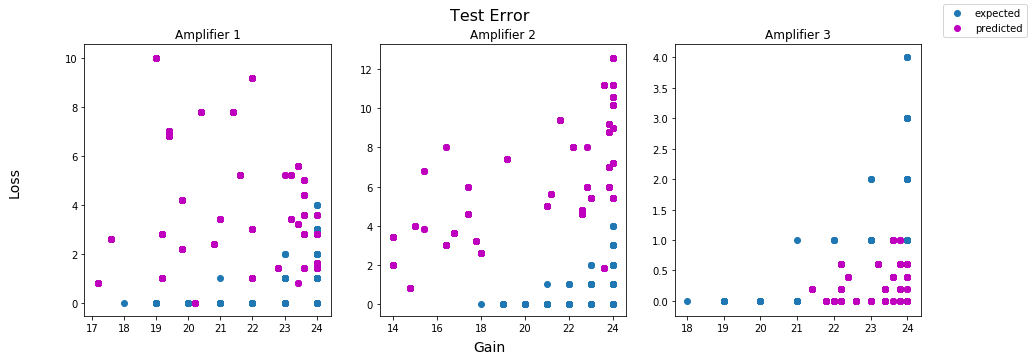

In [14]:
yTest, testResults = plotDistribution(models)

Loss error mean: 1.7913214990138067. Loss error median: 0.9999999999999994
Gain error mean: 1.18966469428008. Gain error median: 0.6000000000000014


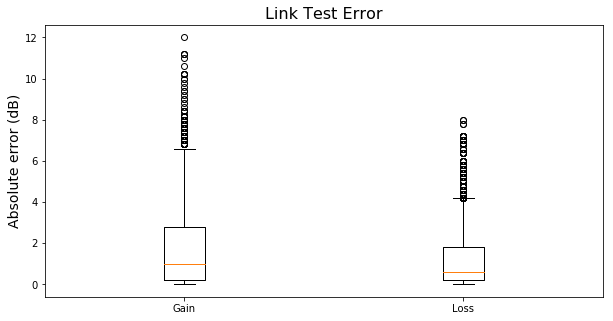

In [15]:
plotLinkTestError(yTest, testResults)

Size splits: [ 225  630 1035 1441 1846 2252]
Train scores: [0.14127386 0.16025687 0.16289091 0.16220754 0.17893554 0.17744271] 
Test scores: [0.18439748 0.18414465 0.18021839 0.17474465 0.18743549 0.18347881] 


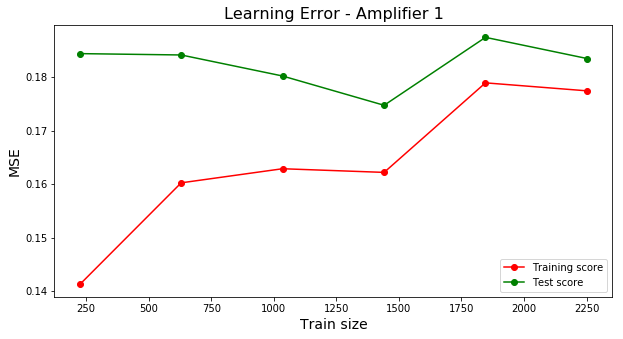

Size splits: [ 225  630 1035 1441 1846 2252]
Train scores: [0.12598631 0.13720221 0.1421038  0.14484157 0.14735533 0.14539582] 
Test scores: [0.17262675 0.15743794 0.15682274 0.15572935 0.1549362  0.15000018] 


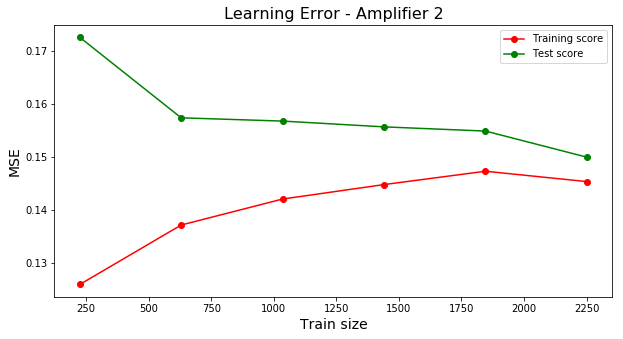

Size splits: [ 225  630 1035 1441 1846 2252]
Train scores: [0.03411226 0.03204734 0.03215099 0.03314151 0.03356705 0.03297065] 
Test scores: [0.03745124 0.03300903 0.03308776 0.03392106 0.03442511 0.03417877] 


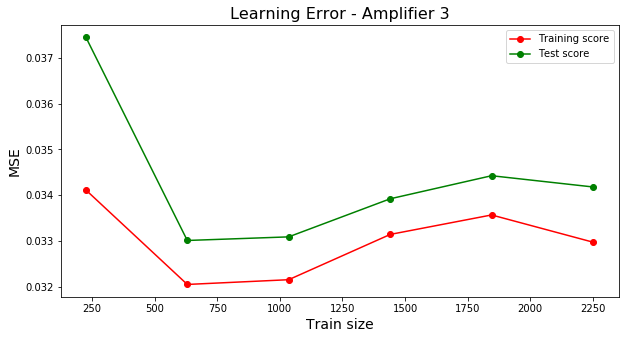

In [17]:
X, y = loadDataset()

plotLearningCurves(0, models[0], X, y[:, 0: 2], 5)
prediction = models[0].predict(X)

for i in range(1, ampNumber):
    newX = np.hstack((X, prediction))
    
    plotLearningCurves(i, models[i], X, y[:, i * 2 : i * 2 + 2], 5)
    prediction = models[i].predict(newX)